<h1 style="text-align: center">
Deep Learning HW4 </br>
VAE and CVAE
</h1>


### Full Name: Mohammadreza Kaboodian
### Student ID: 401207713

# Import necessary libraries

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random
import torchvision

# Define the MNIST dataset and data loader

In [40]:
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 140072810.49it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 40191006.58it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 61296965.21it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 12880682.06it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



# Data Visualization

In [38]:
# Function to display an image
def show_image(image, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    plt.show()

# Function to show random images from each class
def show_random_images_from_each_class(dataset, num_images_per_class=4, figsize=(10, 20)):
    class_labels = list(range(10))
    fig, axs = plt.subplots(len(class_labels), num_images_per_class, figsize=figsize)

    for i, label in enumerate(class_labels):
        class_indices = [idx for idx, target in enumerate(dataset.targets) if target == label]
        random_indices = random.sample(class_indices, num_images_per_class)

        for j, idx in enumerate(random_indices):
            image, target = dataset[idx]
            axs[i, j].imshow(image[0], cmap='gray')
            axs[i, j].set_title(f"Class {label}", fontsize=16)
            axs[i, j].axis('off')
            axs[i, j].set_aspect('equal')
            axs[i, j].grid(True)

    plt.tight_layout()
    plt.show()

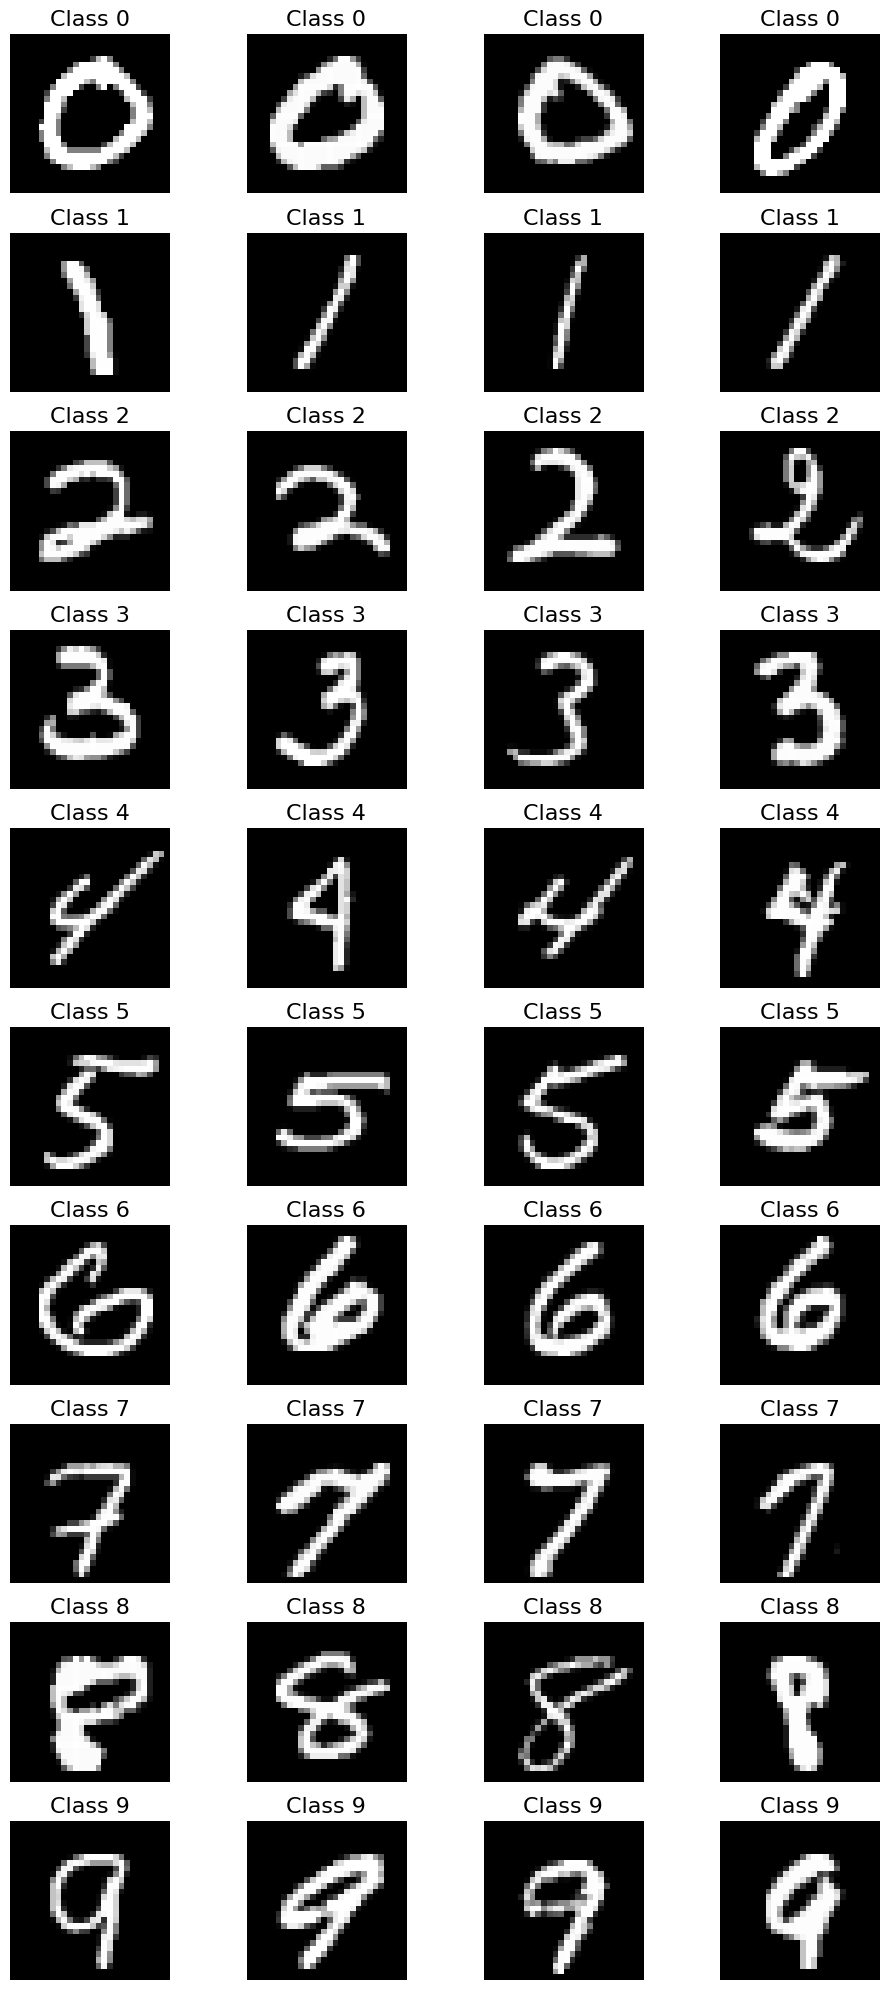

In [41]:
# Use the function to show random images from each class
show_random_images_from_each_class(train_dataset, num_images_per_class=4)

Exercise: Variational Autoencoders (VAE) and Conditional Variational Autoencoders (CVAE)

with MLP Architectures

In this exercise, we'll explore Variational Autoencoders (VAE) and Conditional VAE (CVAE) using PyTorch.

We will implement these models using Multi-Layer Perceptrons (MLP)

Let's get started!

# 1) VAE --> MLP

In [48]:
# Define a simple VAE class with MLP architecture

class VAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder and decoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(2*hidden_dim),
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, latent_dim * 2)  # concatenated mean and variance
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(2*hidden_dim),
            nn.Linear(2*hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.z_2hid = nn.Linear(latent_dim, hidden_dim)
        self.hid_2img = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        epsilon = torch.randn_like(mu)
        return mu +  std * epsilon

    def forward(self, x):
        # encode
        encoded_mu_sigma = self.encoder(x)
        split_index = encoded_mu_sigma.size(1) // 2
        mu = encoded_mu_sigma[:, :split_index]
        logvar = encoded_mu_sigma[:, split_index:]
        # latent
        z_new = self.reparameterize(mu, logvar)
        #decode
        decoded = self.decoder(z_new)
        return decoded, mu, logvar



In [49]:
# Define VAE loss function

def vae_loss(recon, data, mu, logvar):
    # TODO: Implement the reconstruction loss
    reconstruction_loss = nn.BCELoss(reduction="sum")(recon, data)

    # TODO: Implement the KL divergence loss
    kl_divergence = -torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Return the total loss as the sum of reconstruction and KL divergence losses
    return reconstruction_loss + kl_divergence

In [51]:
# Training Loop - VAE (MLP)
def train_vae_mlp(model, train_loader, num_epochs=50, learning_rate=1e-3):
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None
    num_data = 0
    for epoch in range(num_epochs):
        print()
        print(50 * "#")
        total_loss = 0
        for batch_idx, (data, _) in enumerate(train_loader):
            # TODO: Forward process
            num_data += len(data)
            data = data.view(-1, 28 * 28)
            recon, mu, log_var = model(data)

            # TODO: Calculate the loss using the vae_loss function
            loss = vae_loss(recon, data, mu, log_var)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss/num_data
        num_data = 0
        print(f'VAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')

        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_samples = 6  # Generate num_samples random samples
                sample = torch.randn(num_samples, 2)
                sample = model.decoder(sample).view(num_samples, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_samples, figsize=(15, 2))
                for i in range(num_samples):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = model  # TODO: Save the model

    # TODO: Save the best model to a file
    torch.save(model.state_dict(), 'best_vae_mlp_model.pth')
    print("Best model saved as 'best_vae_mlp_model.pth'")



##################################################
VAE-MLP Epoch [1/50], Loss: 197.44854654134116
Sample Images:


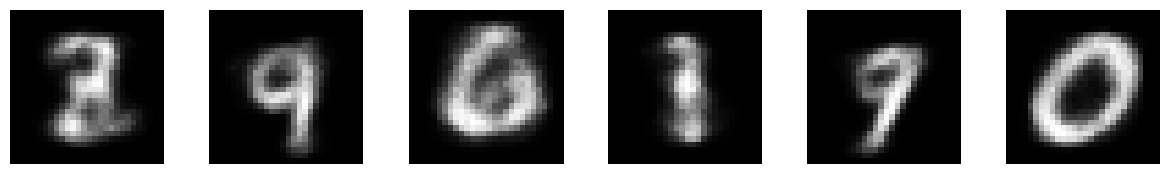


##################################################
VAE-MLP Epoch [2/50], Loss: 164.66645317382813
Sample Images:


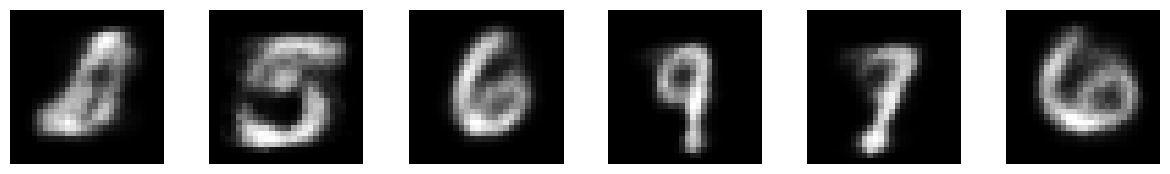


##################################################
VAE-MLP Epoch [3/50], Loss: 162.01458885904947
Sample Images:


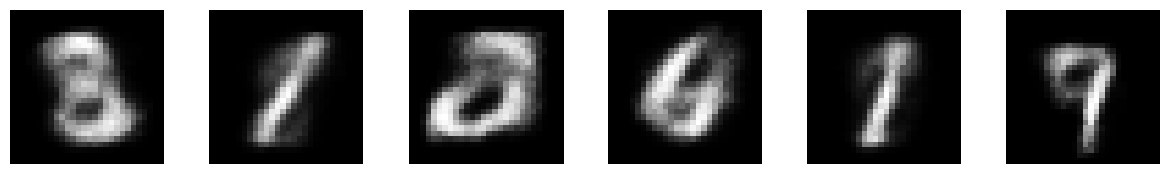


##################################################
VAE-MLP Epoch [4/50], Loss: 160.33049899088542
Sample Images:


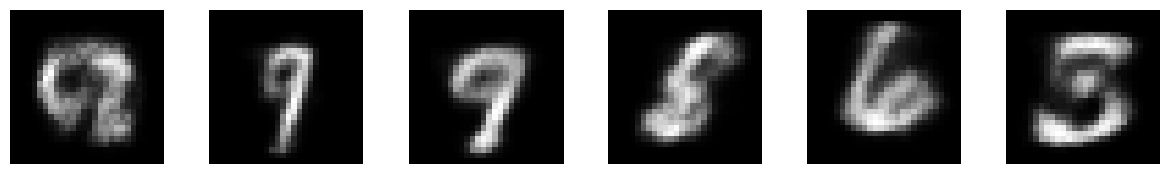


##################################################
VAE-MLP Epoch [5/50], Loss: 158.87716826985678
Sample Images:


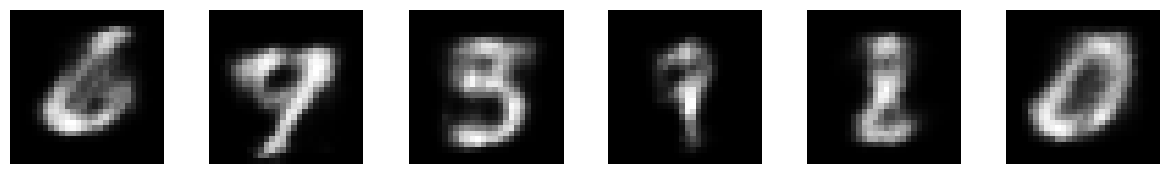


##################################################
VAE-MLP Epoch [6/50], Loss: 158.20846005045573
Sample Images:


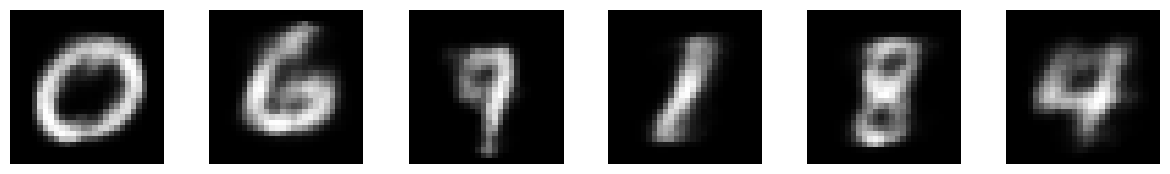


##################################################
VAE-MLP Epoch [7/50], Loss: 157.22297190755208
Sample Images:


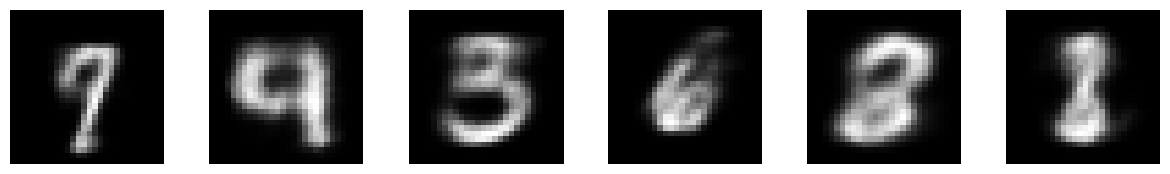


##################################################
VAE-MLP Epoch [8/50], Loss: 156.57330752766927
Sample Images:


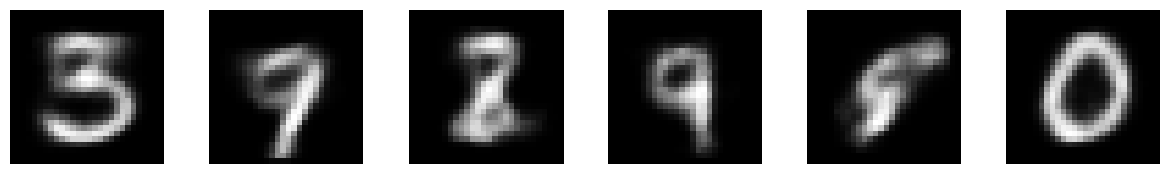


##################################################
VAE-MLP Epoch [9/50], Loss: 155.81825286458334
Sample Images:


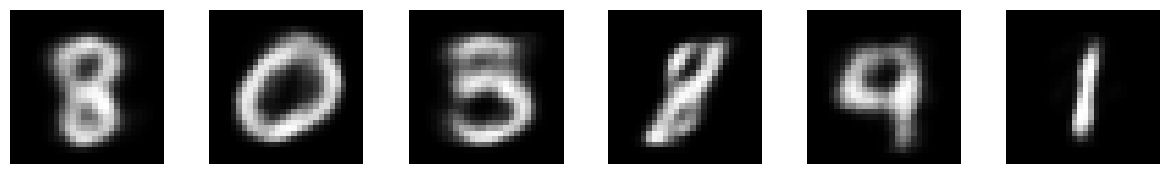


##################################################
VAE-MLP Epoch [10/50], Loss: 155.37984314778646
Sample Images:


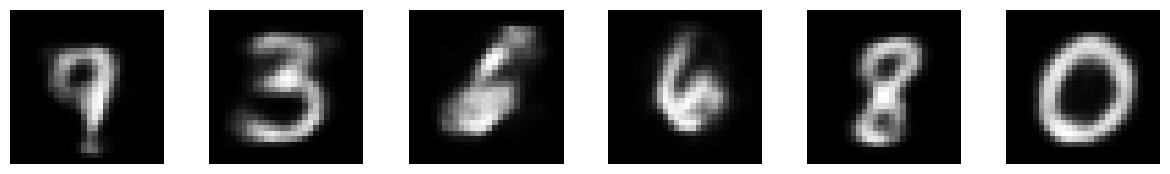


##################################################
VAE-MLP Epoch [11/50], Loss: 155.06556404622395
Sample Images:


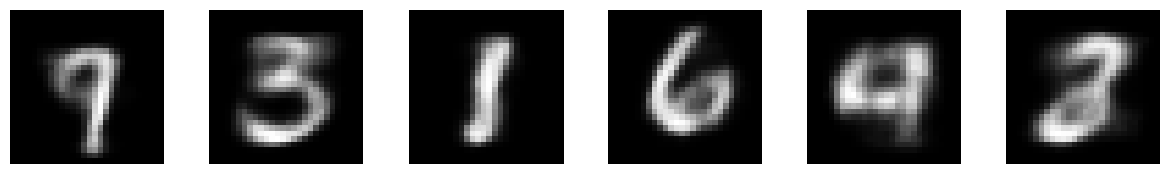


##################################################
VAE-MLP Epoch [12/50], Loss: 154.73496318359375
Sample Images:


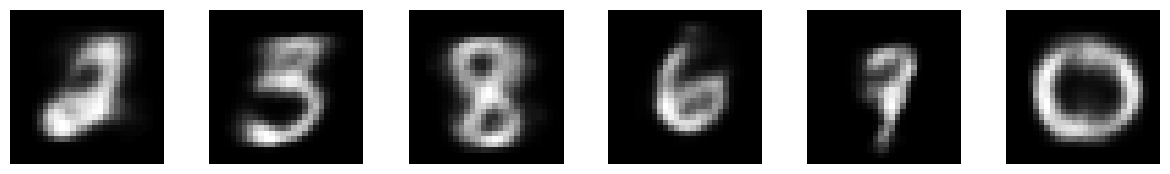


##################################################
VAE-MLP Epoch [13/50], Loss: 154.0017412516276
Sample Images:


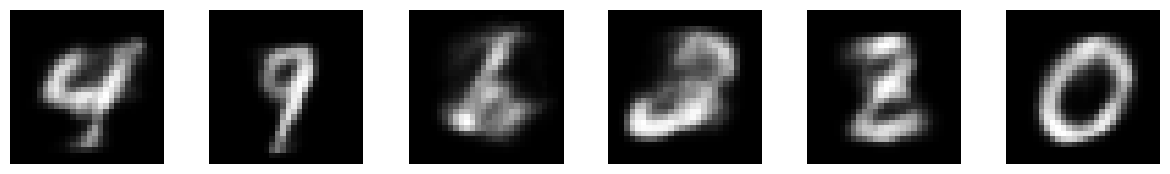


##################################################
VAE-MLP Epoch [14/50], Loss: 153.80772521158855
Sample Images:


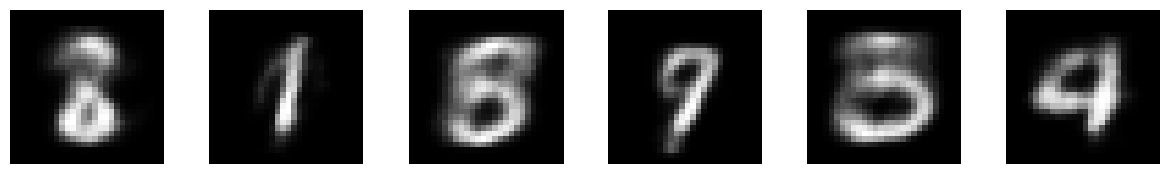


##################################################
VAE-MLP Epoch [15/50], Loss: 153.42065044759116
Sample Images:


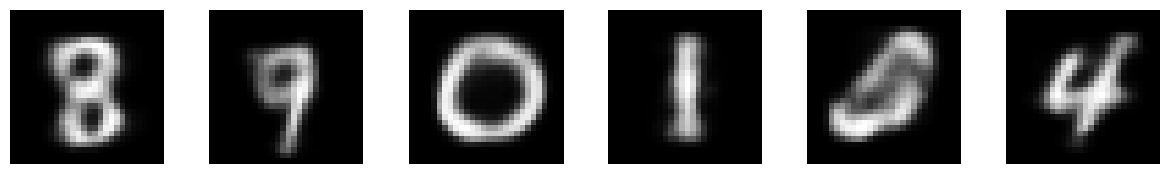


##################################################
VAE-MLP Epoch [16/50], Loss: 153.18372329101564
Sample Images:


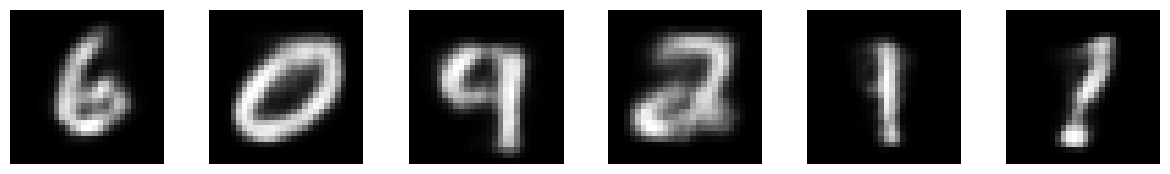


##################################################
VAE-MLP Epoch [17/50], Loss: 152.91704083658854
Sample Images:


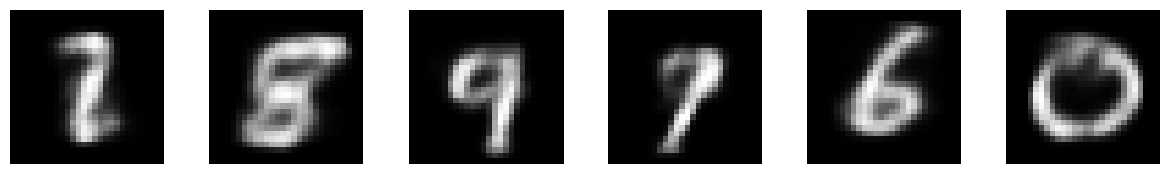


##################################################
VAE-MLP Epoch [18/50], Loss: 152.83713154296876
Sample Images:


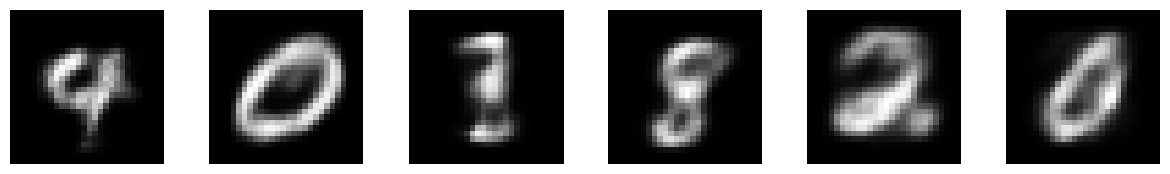


##################################################
VAE-MLP Epoch [19/50], Loss: 152.41428829752604
Sample Images:


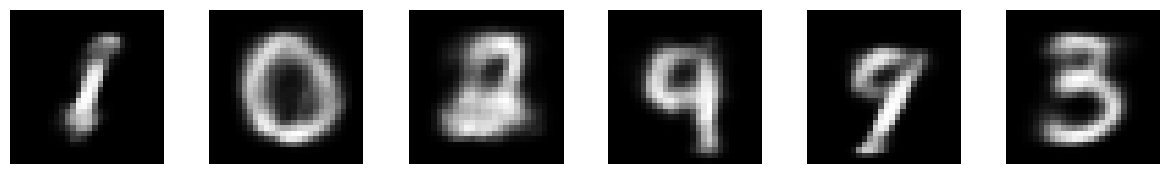


##################################################
VAE-MLP Epoch [20/50], Loss: 152.37118037923176
Sample Images:


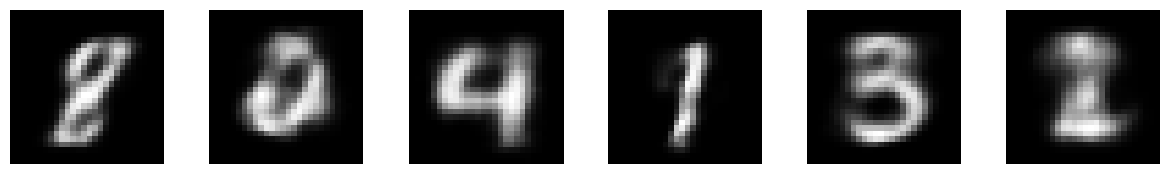


##################################################
VAE-MLP Epoch [21/50], Loss: 152.15603229166666
Sample Images:


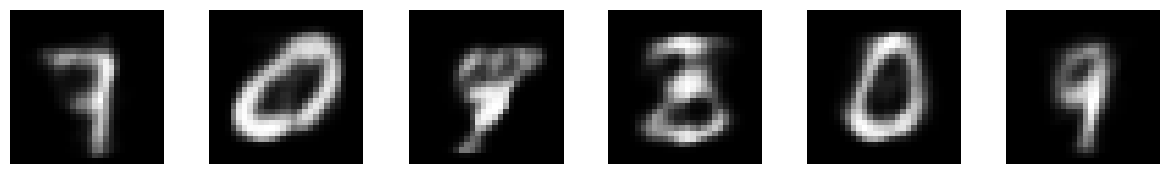


##################################################
VAE-MLP Epoch [22/50], Loss: 151.74734617513022
Sample Images:


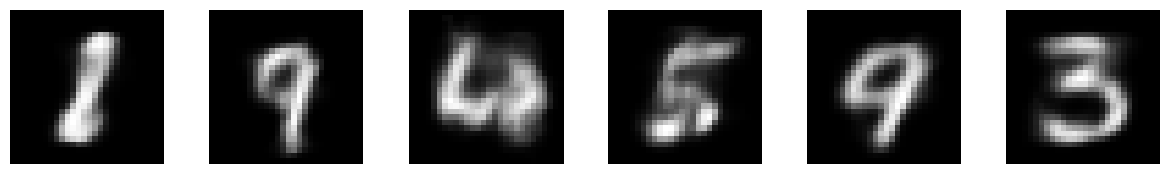


##################################################
VAE-MLP Epoch [23/50], Loss: 151.81697142740884
Sample Images:


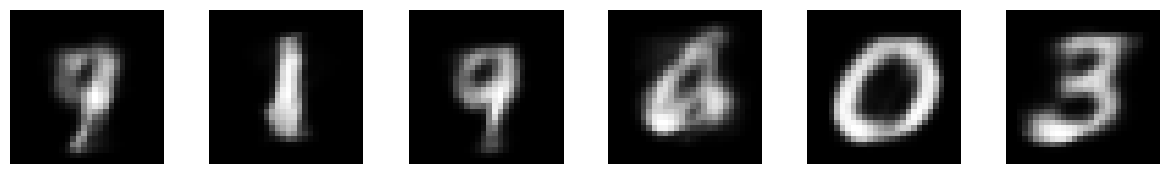


##################################################
VAE-MLP Epoch [24/50], Loss: 151.5878333984375
Sample Images:


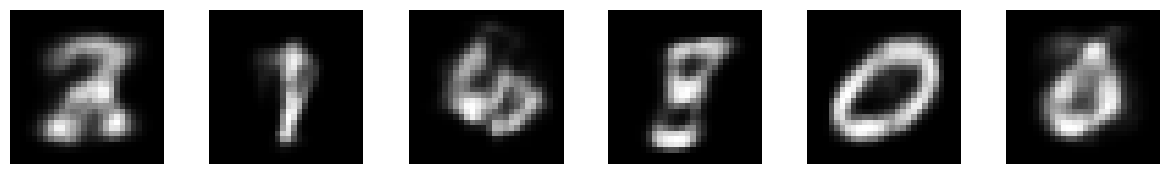


##################################################
VAE-MLP Epoch [25/50], Loss: 151.2196561686198
Sample Images:


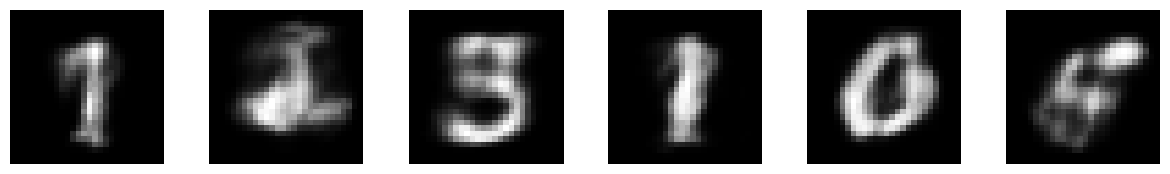


##################################################
VAE-MLP Epoch [26/50], Loss: 151.0399535563151
Sample Images:


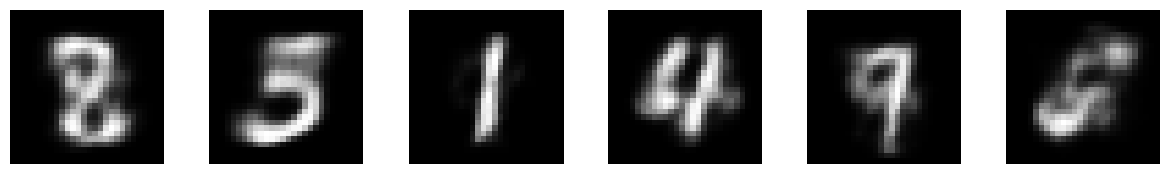


##################################################
VAE-MLP Epoch [27/50], Loss: 151.183010164388
Sample Images:


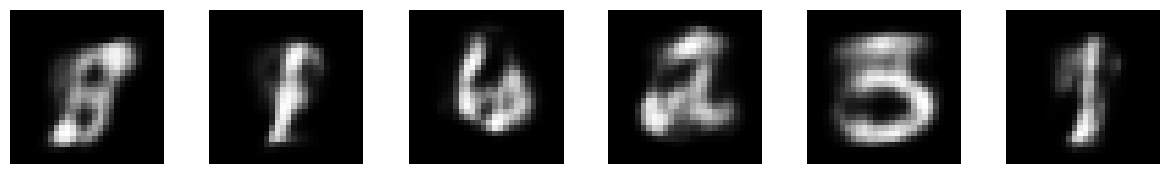


##################################################
VAE-MLP Epoch [28/50], Loss: 150.99166361490884
Sample Images:


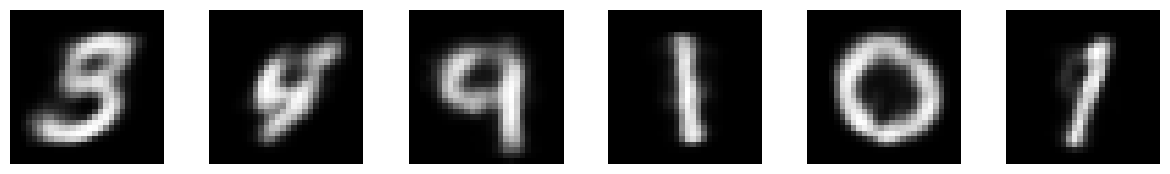


##################################################
VAE-MLP Epoch [29/50], Loss: 150.95386765136718
Sample Images:


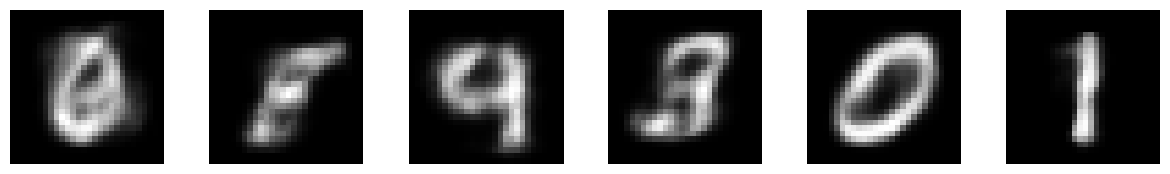


##################################################
VAE-MLP Epoch [30/50], Loss: 150.7494135498047
Sample Images:


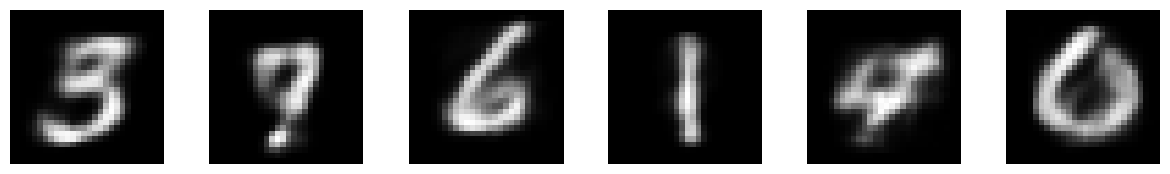


##################################################
VAE-MLP Epoch [31/50], Loss: 150.5419150716146
Sample Images:


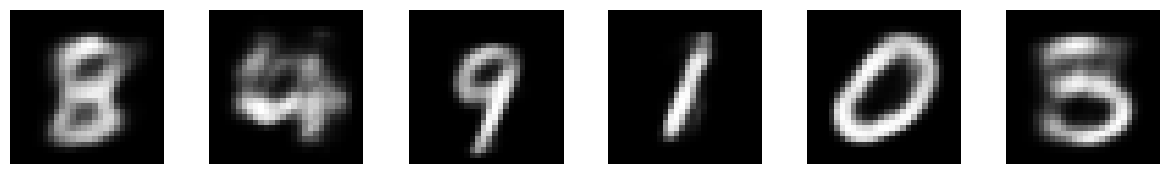


##################################################
VAE-MLP Epoch [32/50], Loss: 150.50994083658856
Sample Images:


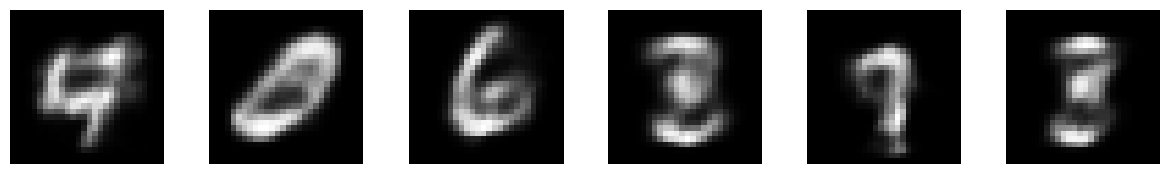


##################################################
VAE-MLP Epoch [33/50], Loss: 150.45038237304686
Sample Images:


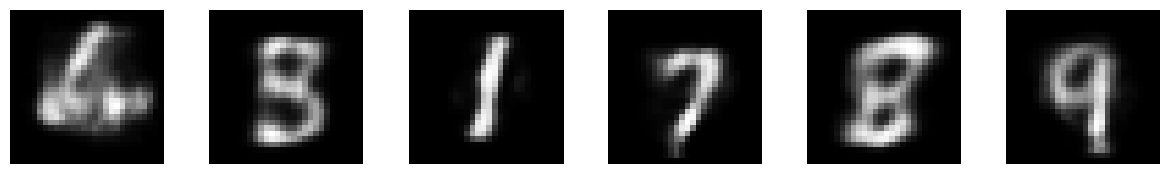


##################################################
VAE-MLP Epoch [34/50], Loss: 150.27025310872395
Sample Images:


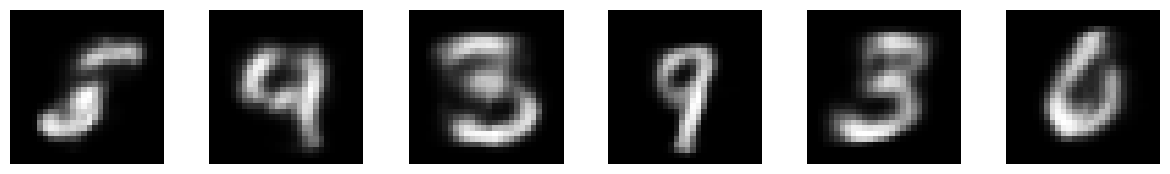


##################################################
VAE-MLP Epoch [35/50], Loss: 150.14589993489582
Sample Images:


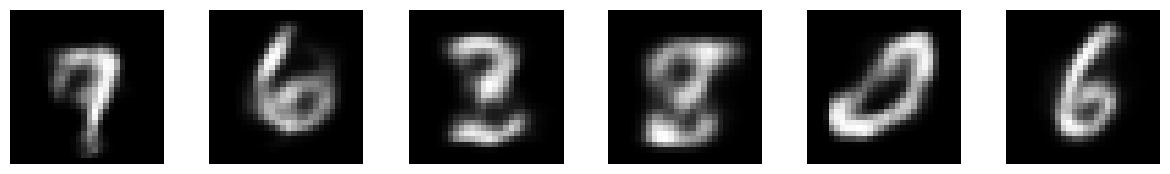


##################################################
VAE-MLP Epoch [36/50], Loss: 150.0913982503255
Sample Images:


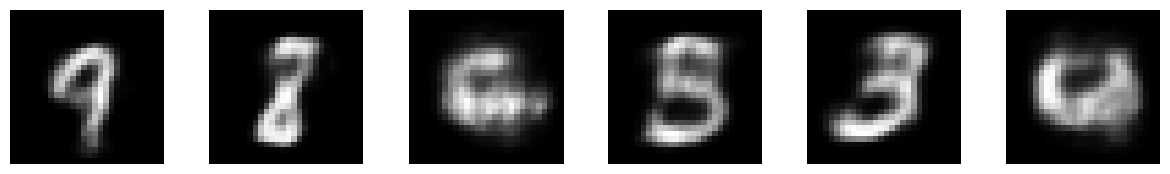


##################################################
VAE-MLP Epoch [37/50], Loss: 150.16055744628906
Sample Images:


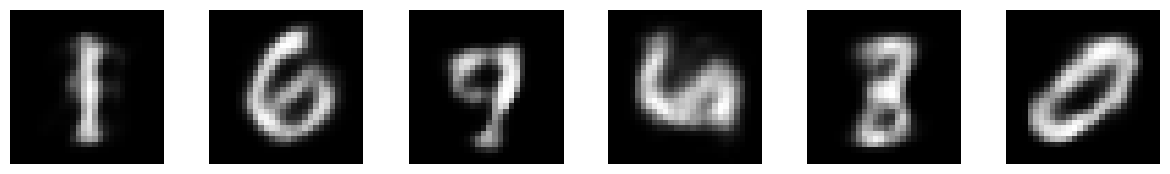


##################################################
VAE-MLP Epoch [38/50], Loss: 150.12621271158855
Sample Images:


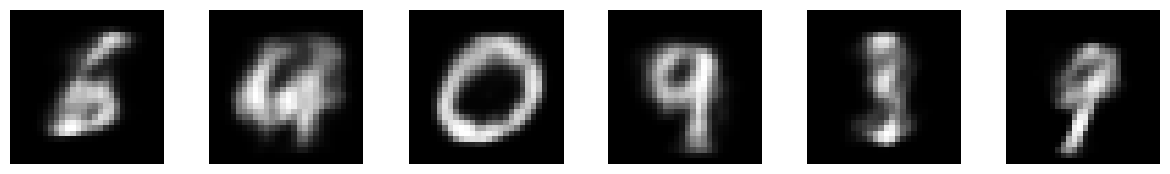


##################################################
VAE-MLP Epoch [39/50], Loss: 149.75336796875
Sample Images:


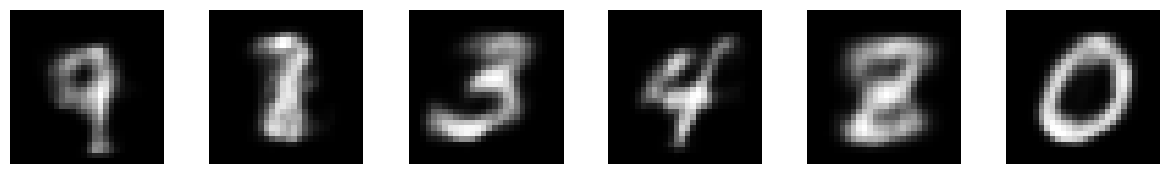


##################################################
VAE-MLP Epoch [40/50], Loss: 149.59006950683593
Sample Images:


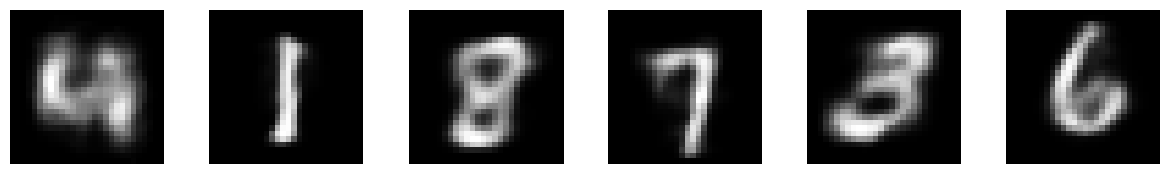


##################################################
VAE-MLP Epoch [41/50], Loss: 149.63862273763021
Sample Images:


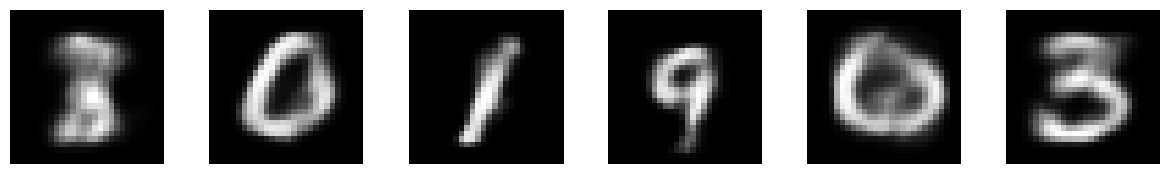


##################################################
VAE-MLP Epoch [42/50], Loss: 149.7103251139323
Sample Images:


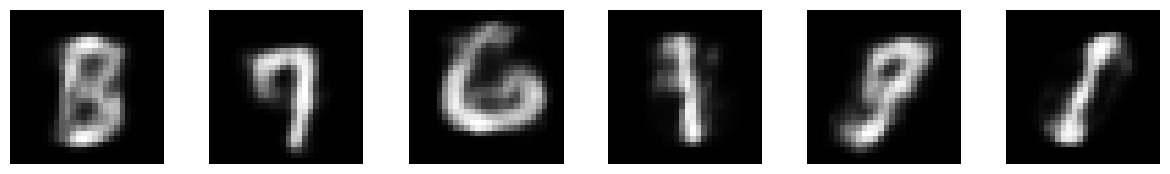


##################################################
VAE-MLP Epoch [43/50], Loss: 149.64508978678384
Sample Images:


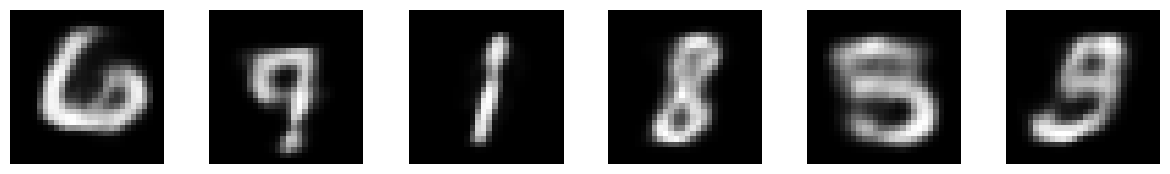


##################################################
VAE-MLP Epoch [44/50], Loss: 149.4321736409505
Sample Images:


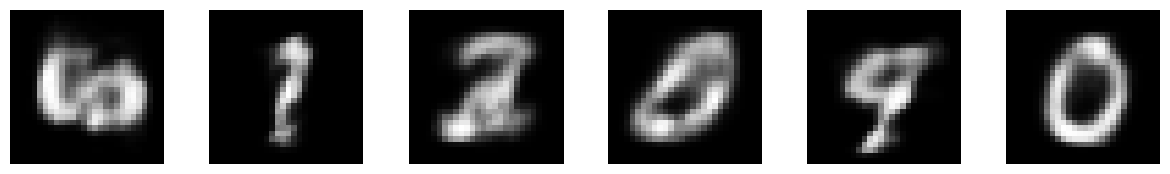


##################################################
VAE-MLP Epoch [45/50], Loss: 149.35355410970053
Sample Images:


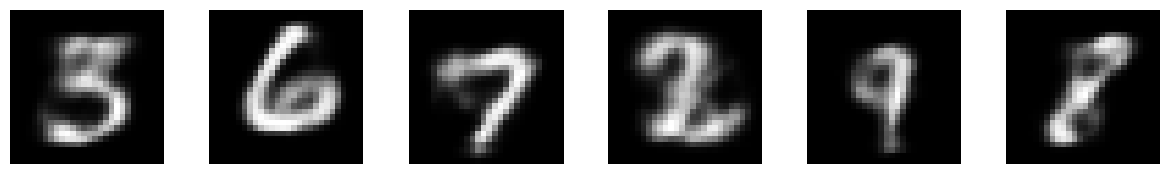


##################################################
VAE-MLP Epoch [46/50], Loss: 149.2447047607422
Sample Images:


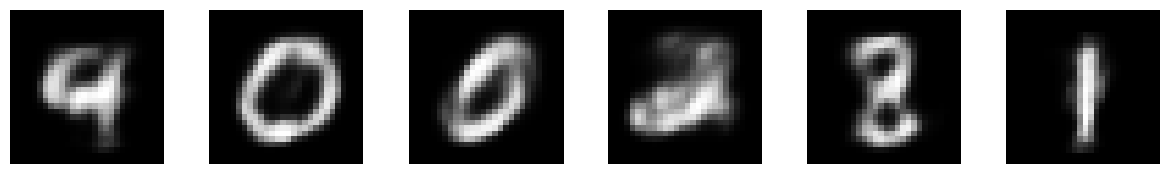


##################################################
VAE-MLP Epoch [47/50], Loss: 149.26178610839844
Sample Images:


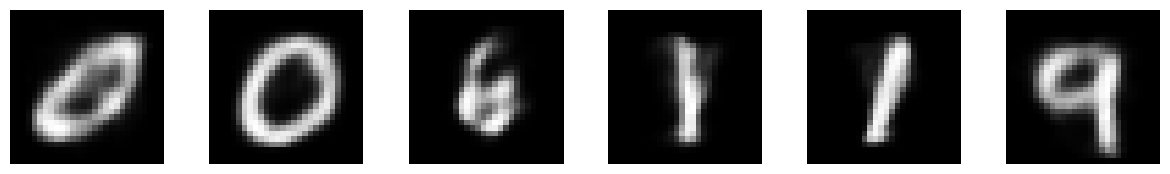


##################################################
VAE-MLP Epoch [48/50], Loss: 149.42931145833333
Sample Images:


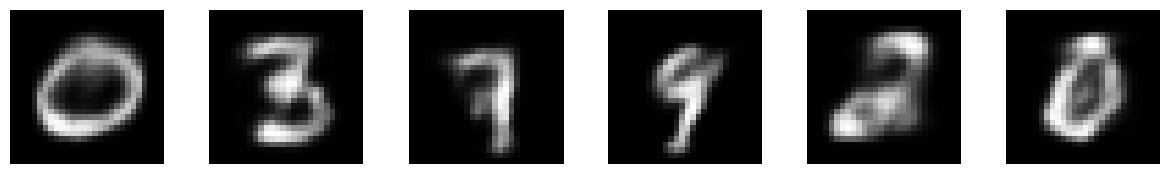


##################################################
VAE-MLP Epoch [49/50], Loss: 148.95615532226563
Sample Images:


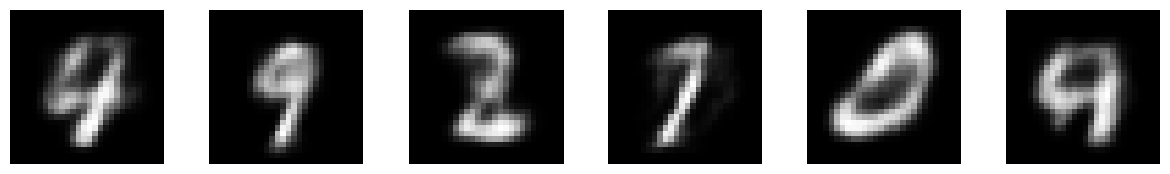


##################################################
VAE-MLP Epoch [50/50], Loss: 149.40249142252605
Sample Images:


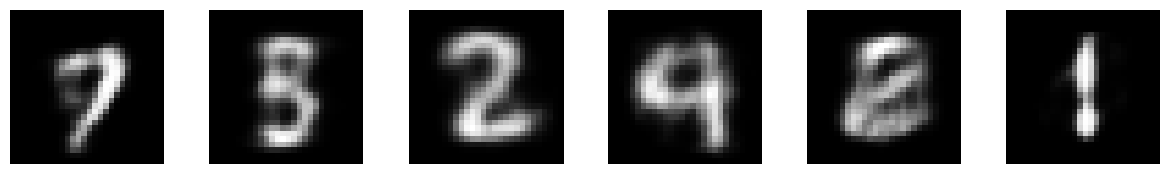

Best model saved as 'best_vae_mlp_model.pth'


In [52]:
# Train VAE-MLP
vae_mlp = VAE_MLP(28*28, 200, 2)
train_vae_mlp(vae_mlp, train_loader)

# 2) CVAE --> MLP

In [34]:
# Define a simple CVAE class with MLP architecture

class CVAE_MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, num_classes):
        super(CVAE_MLP, self).__init__()
        # TODO: Define the architecture of the encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(2*hidden_dim),
            nn.Linear(2*hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, latent_dim * 2)  # concatenated mean and variance
        )
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)
        # TODO: Define the architecture of the decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+num_classes, hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(hidden_dim),
            nn.Linear(hidden_dim, 2*hidden_dim),
            nn.ReLU(),
            nn.BatchNorm1d(2*hidden_dim),
            nn.Linear(2*hidden_dim, input_dim-num_classes),
            nn.Sigmoid()
        )
        self.z_2hid = nn.Linear(latent_dim, hidden_dim)
        self.hid_2img = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc_mu = None
        self.fc_logvar = None
        self.fc_class = None


    def reparameterize(self, mu, logvar):
      std = torch.exp(0.5 * logvar)
      epsilon = torch.randn_like(mu)
      return mu +  std * epsilon

    def forward(self, x, y):
        x = x.view(x.size(0), -1)
        y = y.view(y.size(0), -1)

        # TODO: Concatenate x and y before passing them to the encoder
        x = torch.cat([x, y], 1) # (bs, feature_size+class_size)

        # TODO: Implement the forward pass
        encoded_mu_sigma = self.encoder(x)
        split_index = encoded_mu_sigma.size(1) // 2
        mu = encoded_mu_sigma[:, :split_index]
        logvar = encoded_mu_sigma[:, split_index:]
        # latent
        z_new = self.reparameterize(mu, logvar)
        #decode
        z = torch.cat([z_new, y], 1) # (bs, feature_size+latent_size)
        reconstructed = self.decoder(z)
        class_logits = y

        return reconstructed, mu, logvar, class_logits




In [29]:
# Define CVAE loss function
def cvae_loss(recon, data, mu, logvar, class_logits, labels):
    # TODO: Flatten the data tensor
    data = data.view(-1, 784)

    # TODO: Implement the reconstruction loss
    # print(recon.shape, data.shape)
    reconstruction_loss = nn.BCELoss(reduction="sum")(recon, data)

    # TODO: Implement the KL divergence loss
    kl_divergence = -torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    # TODO: Implement the cross-entropy loss for class prediction
    ce_loss = None

    # TODO: Return the total loss as the sum of reconstruction, KL divergence, and cross-entropy losses
    return reconstruction_loss + kl_divergence


In [46]:
# Training Loop - CVAE (MLP)
def train_cvae_mlp(model, train_loader, num_epochs=10, learning_rate=1e-3):
    model.train()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    best_loss = float('inf')  # Initialize with a high value
    best_model = None
    num_data = 0
    for epoch in range(num_epochs):
        model.to(device)
        print()
        print(50 * "#")
        total_loss = 0

        for batch_idx, (data, labels) in enumerate(train_loader):
            num_data += len(data)
            optimizer.zero_grad()
            # One-hot encode the labels
            class_size = 10
            labels_one_hot = torch.zeros(labels.size(0), class_size)
            for i, label in enumerate(labels):
                labels_one_hot[i, label] = 1
            labels_one_hot = labels_one_hot.to(device)
            data = data.to(device)
            # print("data,", data.shape)


            # TODO: Forward pass through the model and calculate the loss using cvae_loss
            recon, mu, log_var,class_logits = model(data, labels_one_hot)
            loss = cvae_loss(recon, data, mu, log_var, class_logits, labels_one_hot)

            # TODO: Backpropagation and optimization step
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss = total_loss + loss.item()

        avg_loss = total_loss/num_data
        num_data = 0
        print(f'CVAE-MLP Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss}')
        model.to("cpu")
        # Show some sample images after each epoch
        if (epoch + 1) % 1 == 0:
            print("Sample Images:")
            with torch.no_grad():
                num_classes = 10  # Number of classes (0 to 9)
                num_samples_per_class = 1  # One sample per class
                # Generate random samples
                z = torch.randn(num_classes * num_samples_per_class, 2)
                # Generate one-hot encoded class labels
                y = torch.eye(num_classes).repeat(num_samples_per_class, 1)
                # Concatenate the random samples and class labels before passing them to the decoder
                sample = torch.cat([z, y], dim=1)
                sample = model.decoder(sample).view(num_classes * num_samples_per_class, 1, 28, 28)
                sample = sample.squeeze().cpu()
                fig, axs = plt.subplots(1, num_classes, figsize=(15, 2))
                for i in range(num_classes):
                    axs[i].imshow(sample[i], cmap='gray')
                    axs[i].set_title(f"Class {i}", fontsize=16)
                    axs[i].axis('off')
                plt.show()

        # TODO: Save the best model based on loss
        if avg_loss < best_loss:
            best_loss = avg_loss
            best_model = None

    # TODO: Save the best model to a file
    None
    print("Best model saved as 'best_cvae_mlp_model.pth'")



##################################################
CVAE-MLP Epoch [1/10], Loss: 174.26078360188802
Sample Images:


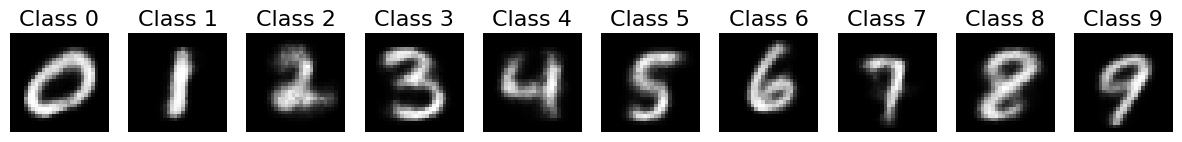


##################################################
CVAE-MLP Epoch [2/10], Loss: 71.38506435139973
Sample Images:


Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/queues.py", line 239, in _feed
    reader_close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.10/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


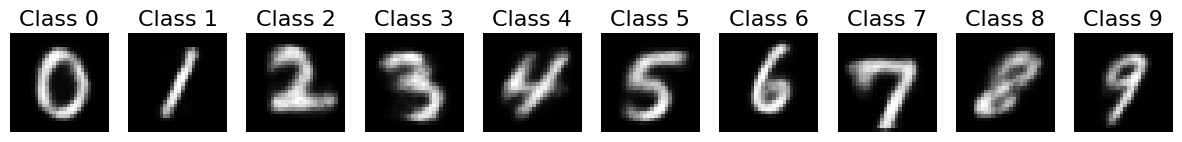


##################################################
CVAE-MLP Epoch [3/10], Loss: 47.0160290093316
Sample Images:


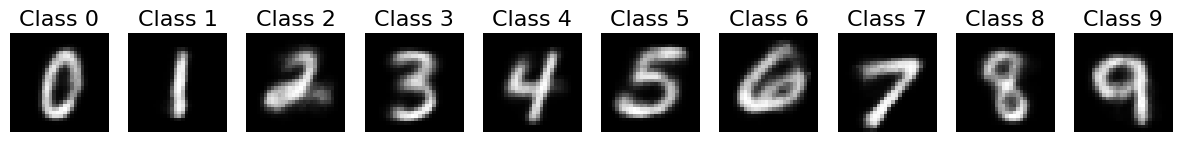


##################################################
CVAE-MLP Epoch [4/10], Loss: 34.98969630330404
Sample Images:


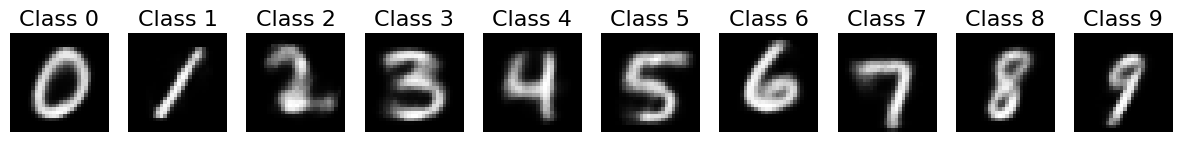


##################################################
CVAE-MLP Epoch [5/10], Loss: 27.87830310546875
Sample Images:


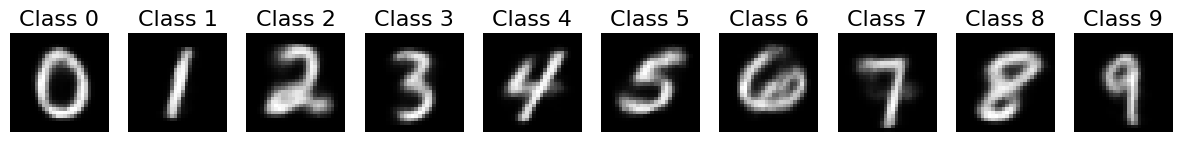


##################################################
CVAE-MLP Epoch [6/10], Loss: 23.13325608452691
Sample Images:


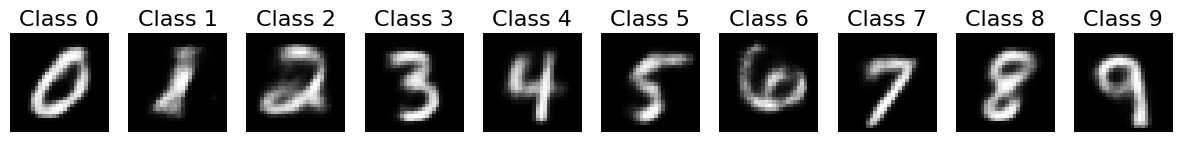


##################################################
CVAE-MLP Epoch [7/10], Loss: 19.779475389462426
Sample Images:


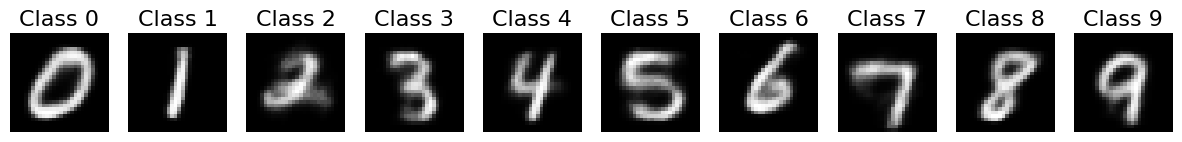


##################################################
CVAE-MLP Epoch [8/10], Loss: 17.261410564168294
Sample Images:


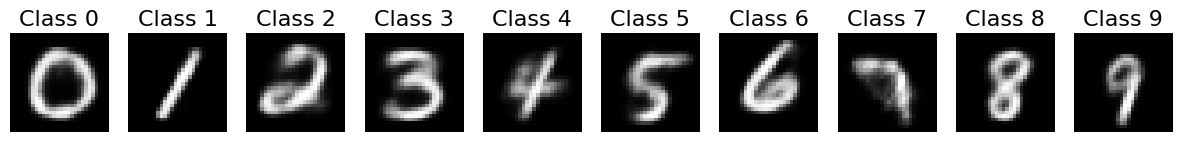


##################################################
CVAE-MLP Epoch [9/10], Loss: 15.307610015190972
Sample Images:


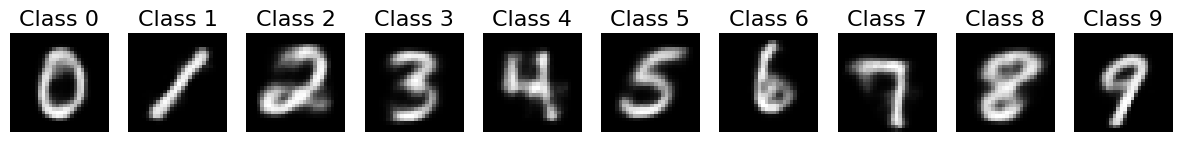


##################################################
CVAE-MLP Epoch [10/10], Loss: 13.743760576171875
Sample Images:


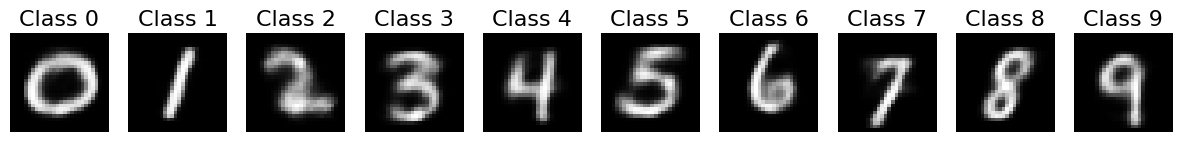

Best model saved as 'best_cvae_mlp_model.pth'


In [47]:
cvae_mlp = CVAE_MLP(28*28+10, 200, 2, 10)
train_cvae_mlp(cvae_mlp, train_loader)

# 3) Visualizing Latent Space Distribution in Two Models

In this section, we will visualize the latent space distribution for two different models:

## Latent Space Distribution:

### VAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in VAE model.
2. Analyze the characteristics of the distribution.

### CVAE (MLP):

1. Visualize the latent space distribution using Multilayer Perceptron (MLP) in CVAE model.
2. Analyze the characteristics of the distribution.


Summarize your findings and draw conclusions based on the observed differences in the latent space distribution between VAE (MLP) and CVAE (MLP).


In [66]:
all_labels = []
all_z = []
vae_mlp.to(device)
with torch.no_grad():
  for batch_idx, (data, labels) in enumerate(train_loader):
    class_size = 10
    # labels_one_hot = torch.zeros(labels.size(0), class_size)
    # for i, label in enumerate(labels):
    #     labels_one_hot[i, label] = 1
    # labels_one_hot = labels_one_hot.to(device)
    data = data.to(device)
    data = data.view(-1,28*28)
    # print("data,", data.shape)

    encoded_mu_sigma = vae_mlp.encoder(data)
    split_index = encoded_mu_sigma.size(1) // 2
    mu = encoded_mu_sigma[:, :split_index]
    logvar = encoded_mu_sigma[:, split_index:]
    z_new = vae_mlp.reparameterize(mu, logvar).cpu()
    all_z.append(z_new)
    for lbl in labels:
      all_labels.append(lbl.item())
  all_z = torch.cat(all_z, dim=0)
  all_labels = torch.tensor(all_labels)




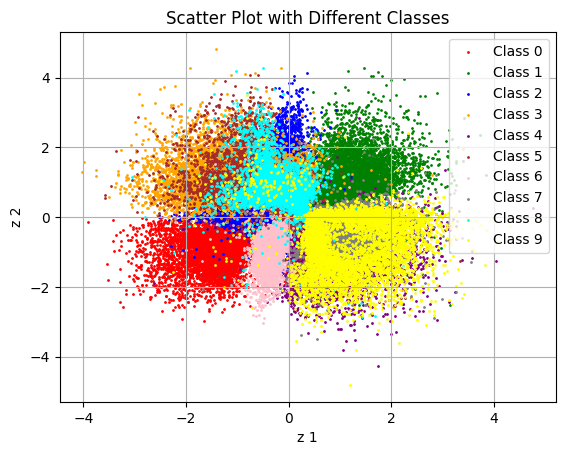

In [74]:
# defining colors for each class
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'yellow']

# scatter plot with different colors
for class_label in np.unique(all_labels):
    class_data = all_z[all_labels == class_label]
    plt.scatter(class_data[:, 0], class_data[:, 1], c=colors[class_label], label=f'Class {class_label}',s=1)

# Customize plot
plt.title('Scatter Plot with Different Classes')
plt.xlabel('z 1')
plt.ylabel('z 2')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## CVAE

In [77]:
all_labels = []
all_z = []
cvae_mlp.to(device)
with torch.no_grad():
  for batch_idx, (data, labels) in enumerate(train_loader):
    class_size = 10
    labels_one_hot = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        labels_one_hot[i, label] = 1
    labels_one_hot = labels_one_hot.to(device)
    data = data.to(device)
    data = data.view(-1,28*28)
    # print("data,", data.shape)
    data1 = torch.cat([data, labels_one_hot], dim=1)
    encoded_mu_sigma = cvae_mlp.encoder(data1)
    split_index = encoded_mu_sigma.size(1) // 2
    mu = encoded_mu_sigma[:, :split_index]
    logvar = encoded_mu_sigma[:, split_index:]
    z_new = cvae_mlp.reparameterize(mu, logvar).cpu()
    all_z.append(z_new)
    for lbl in labels:
      all_labels.append(lbl.item())
  all_z = torch.cat(all_z, dim=0)
  all_labels = torch.tensor(all_labels)



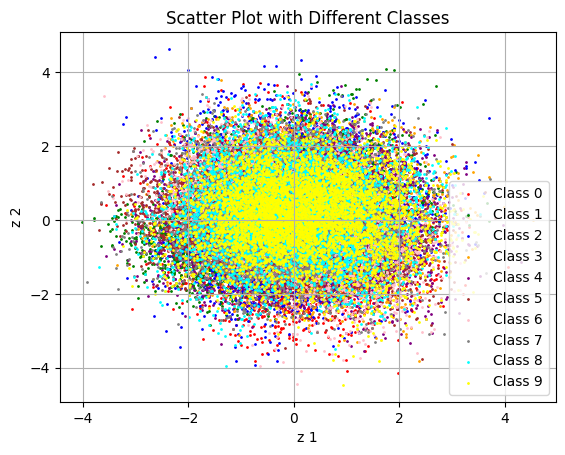

In [78]:
# defining colors for each class
colors = ['red', 'green', 'blue', 'orange', 'purple', 'brown', 'pink', 'gray', 'cyan', 'yellow']

# scatter plot with different colors
for class_label in np.unique(all_labels):
    class_data = all_z[all_labels == class_label]
    plt.scatter(class_data[:, 0], class_data[:, 1], c=colors[class_label], label=f'Class {class_label}',s=1)

# Customize plot
plt.title('Scatter Plot with Different Classes')
plt.xlabel('z 1')
plt.ylabel('z 2')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


همان طور که مشاهده می کنیم، در اتوانکودر اول داده ها در فضای مخفی همه در یک توزی گوسی واحد با میانگین صفر قرار گرفتند و داده های هر کلاس تقریبا نزدیک به هم هستند .
(ممکن است کلاس های شبیه به هم مثل 8 و 3 نزدیک به هم باشند و یک تکه نباشند.)
در اتوانکودر دوم مانند اول همه در یک توزیع گوسی اند . با این تفاوت که همهی ی کلاس ها هم همین توزیع را دارند و مانند اتوانکودر اول افراز نشده اند. چون در واقع توزیع شرط آن را لحاظ نکردیم و اگر آن را هم به گونه ای در نمایش می گنجاندیم ،آن هم حالت افراز مانند برای هر کلاس داشت